# Linear Regression

In [2]:
import torch
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random

## 生成数据集
构造一个简单的人工训练数据集。我们设置训练数据集样本数1000，输入特征数为2。给定随机生成的批量样本特征$X\in R^{1000\times 2}$，并采用一个随机噪声项来生成标签。
其中噪声项$\epsilon$服从均值为0，标准差为0.01的正态分布。

In [3]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype = torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] +true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),dtype=torch.float32)

In [4]:
print(features[0], labels[0])

tensor([0.7050, 0.3165]) tensor(4.5302)


C:\Users\ZHANGWEIMING\AppData\Local\Temp\ipykernel_27232\205517339.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


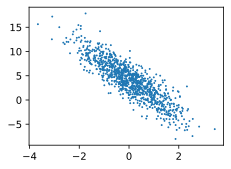

In [5]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);


## 读取数据
在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。在这里定义一个函数：每次返回`batch_size`大小个随机样本的特征和标签。

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)# 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i+batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

在这里我们试着读取批量数据样本并打印。每个批量的特征形状为(10,2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [7]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X,y)
    break

tensor([[-2.8413,  0.6934],
        [-1.8095, -1.0653],
        [-0.0550,  0.4893],
        [ 1.6099, -1.2566],
        [-1.1119, -3.1009],
        [ 0.3119, -0.6920],
        [ 0.3847, -1.8289],
        [ 2.0663,  0.6579],
        [ 0.0622, -2.2025],
        [ 0.3411,  0.4413]]) tensor([-3.8425,  4.1989,  2.4325, 11.6891, 12.5202,  7.1689, 11.1768,  6.0984,
        11.8274,  3.3987])


## 初始化模型参数
我们将权重初始化为均值为0，标准差为0.01的正态随机数，偏差bias初始化为0。
我们将`requires_grad=True`以方便后面梯度下降。

In [8]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 定义模型
下面是线性回归的矢量计算式的实现。我们使用`mm`函数做矩阵乘法。

In [9]:
def linreg(X, w, b): 
    return torch.mm(X, w) + b

## 定义损失函数
在这里采用平方损失来定义线性回归的损失函数。

In [10]:
def squared_loss(y_hat, y):  
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 定义优化算法
`sgd`函数实现了批量随机梯度下降的算法。通过不断迭代模型来优化损失函数。这里自动求梯度

In [11]:
def sgd(params, lr, batch_size):  
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 训练模型
在训练中，我们多次迭代模型参数。我们根据当前读取的小批量数据样本（特征X和标签y），通过调用反向函数`backward`来计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小为10，每个小批量损失`l`的形状是(10,1)。回忆一下自动求梯度一节。由于变量`l`并不是一个标量，所以我们调用`.sum()`将其求和得到一个标量，再运行`l.backward()`得到变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

In [12]:
lr = 0.03
num_epochs = 100
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))


epoch 1, loss 0.040039
epoch 2, loss 0.000150
epoch 3, loss 0.000051
epoch 4, loss 0.000051
epoch 5, loss 0.000051
epoch 6, loss 0.000051
epoch 7, loss 0.000051
epoch 8, loss 0.000051
epoch 9, loss 0.000051
epoch 10, loss 0.000051
epoch 11, loss 0.000051
epoch 12, loss 0.000051
epoch 13, loss 0.000051
epoch 14, loss 0.000051
epoch 15, loss 0.000051
epoch 16, loss 0.000051
epoch 17, loss 0.000051
epoch 18, loss 0.000051
epoch 19, loss 0.000051
epoch 20, loss 0.000051
epoch 21, loss 0.000051
epoch 22, loss 0.000051
epoch 23, loss 0.000051
epoch 24, loss 0.000051
epoch 25, loss 0.000051
epoch 26, loss 0.000051
epoch 27, loss 0.000051
epoch 28, loss 0.000051
epoch 29, loss 0.000051
epoch 30, loss 0.000051
epoch 31, loss 0.000051
epoch 32, loss 0.000051
epoch 33, loss 0.000051
epoch 34, loss 0.000051
epoch 35, loss 0.000051
epoch 36, loss 0.000051
epoch 37, loss 0.000051
epoch 38, loss 0.000051
epoch 39, loss 0.000051
epoch 40, loss 0.000051
epoch 41, loss 0.000051
epoch 42, loss 0.000051
e

In [42]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9999],
        [-3.3999]], requires_grad=True)
4.2 
 tensor([4.2004], requires_grad=True)
